In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.io import read_video
from torchvision.transforms.functional import convert_image_dtype

import torchvision.transforms.functional as F
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50

In [10]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    finally:
        cap.release()

    return np.array(frames, dtype=np.uint8)

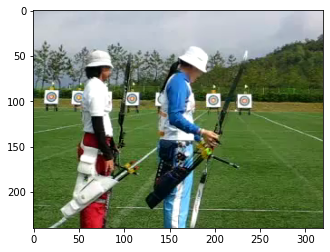

In [69]:
video, _, _ = read_video("archery.mp4")
batch = convert_image_dtype(video[:4], dtype=torch.float)
plt.imshow(video[0])

In [70]:
#model = fcn_resnet50(pretrained=True, progress=False)
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

normalized_batch = F.normalize(batch.permute(0, 3, 1, 2), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = model(normalized_batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([4, 21, 240, 320]) -4.52379846572876 14.99803638458252


In [71]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

person_mask = [
    normalized_masks[img_idx, sem_class_to_idx['person']]
    for img_idx in range(batch.shape[0])
]

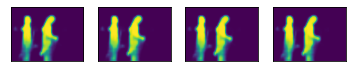

In [72]:
show(person_mask)

shape = torch.Size([4, 240, 320]), dtype = torch.bool


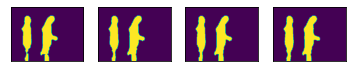

In [73]:
class_dim = 1
boolean_person_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['person'])
print(f"shape = {boolean_person_masks.shape}, dtype = {boolean_person_masks.dtype}")
show([m.float() for m in boolean_person_masks])